In [1]:
import pandas as pd
from rdkit import Chem
import math
import seaborn as sns
from matplotlib import pyplot as plt
from tqdm.auto import tqdm
from tdc.single_pred import ADME
from rdkit.Chem.Draw import IPythonConsole

In [2]:
tqdm.pandas()

In [3]:
sol_df = pd.read_csv('./data/solubility.csv')

Get some information about your data

In [4]:
sol_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9983 entries, 0 to 9982
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Name    9983 non-null   object 
 1   SMILES  9983 non-null   object 
 2   LogS    9982 non-null   float64
dtypes: float64(1), object(2)
memory usage: 234.1+ KB


##### Dealing with Nan/Null Values

The LogS folder has 1 null value. Find out which one it is.

In [5]:
sol_df[sol_df['LogS'].isna()]

,Name,SMILES,LogS
9982,benzene,c1ccccc1,NaN


You can do 3 things to with null values, fill them, replace them, or drop/remove them. 

In [6]:
# fill with mean value in the data
new = sol_df['LogS'].fillna(sol_df['LogS'].mean())
print(new.loc[9982])

-2.9900149458408833


In [7]:
# replace with 0
sol_df.replace(math.nan, 0)

,Name,SMILES,LogS
0,"N,N,N-trimethyloctadecan-1-aminium bromide",CCCCCCCCCCCCCCCCCC[N+](C)(C)C.[Br-],-3.616127
1,Benzo[cd]indol-2(1H)-one,O=C1Nc2cccc3cccc1c23,-3.254767
2,4-chlorobenzaldehyde,O=Cc1ccc(Cl)cc1,-2.177078
3,"zinc bis[2-hydroxy-3,5-bis(1-phenylethyl)benzo...",CC(c1ccccc1)c1cc(C(=O)[O-])c(O)c(C(C)c2ccccc2)...,-3.924409
4,4-({4-[bis(oxiran-2-ylmethyl)amino]phenyl}meth...,c1cc(N(CC2CO2)CC2CO2)ccc1Cc1ccc(N(CC2CO2)CC2CO...,-4.662065
...,...,...,...
9978,tetracycline,CN(C)[C@@H]1C(O)=C(C(N)=O)C(=O)[C@@]2(O)C(O)=C...,-2.930000
9979,thymol,Cc1ccc(C(C)C)c(O)c1,-2.190000
9980,verapamil,COc1ccc(CCN(C)CCCC(C#N)(c2ccc(OC)c(OC)c2)C(C)C...,-3.980000
9981,warfarin,CC(=O)CC(c1ccccc1)c1c(O)c2ccccc2oc1=O,-4.780000


In [8]:
# drop the entire row, we are going to do that here.
sol_df.dropna(inplace=True)

Now none of the columns have null values

In [9]:
sol_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9982 entries, 0 to 9981
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Name    9982 non-null   object 
 1   SMILES  9982 non-null   object 
 2   LogS    9982 non-null   float64
dtypes: float64(1), object(2)
memory usage: 311.9+ KB


In [10]:
sol_df.tail(5)

,Name,SMILES,LogS
9977,tetracaine,CCCCNc1ccc(C(=O)OCCN(C)C)cc1,-3.01
9978,tetracycline,CN(C)[C@@H]1C(O)=C(C(N)=O)C(=O)[C@@]2(O)C(O)=C...,-2.93
9979,thymol,Cc1ccc(C(C)C)c(O)c1,-2.19
9980,verapamil,COc1ccc(CCN(C)CCCC(C#N)(c2ccc(OC)c(OC)c2)C(C)C...,-3.98
9981,warfarin,CC(=O)CC(c1ccccc1)c1c(O)c2ccccc2oc1=O,-4.78


##### Dealing with Outliers

Now next, we look for outliers

In [11]:
sol_df['LogS'].describe()

count    9982.000000
mean       -2.990015
std        10.257182
min     -1000.000000
25%        -4.328225
50%        -2.619050
75%        -1.210000
max         2.137682
Name: LogS, dtype: float64

As you see here, the minimum LogS value is -1000. This value seems unphysical. Lets dig deeper. Make a box plot or a histrogram. These plots are used to show the distribution of your data and often for comparing distribtutions. 

<Axes: xlabel='LogS'>

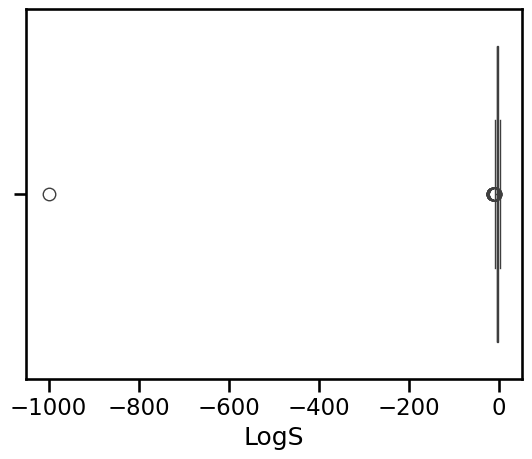

In [12]:
sns.set_context('talk')
sns.boxplot(sol_df['LogS'], orient='h')

<Axes: >

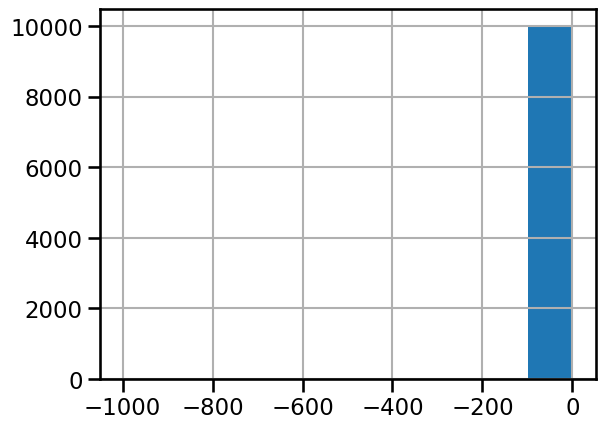

In [13]:
sol_df['LogS'].hist(bins=10)

These clearly show that 1 unphysical outlier exists which is -1000. There maybe more. Lets remove the value which is -1000 and then see

In [14]:
sol_df = sol_df[sol_df['LogS'] != -1000]

In [15]:
sol_df.describe()

,LogS
count,9981.000000
mean,-2.890124
std,2.368175
min,-13.171900
25%,-4.326500
50%,-2.618300
75%,-1.210000
max,2.137682


<Axes: xlabel='LogS'>

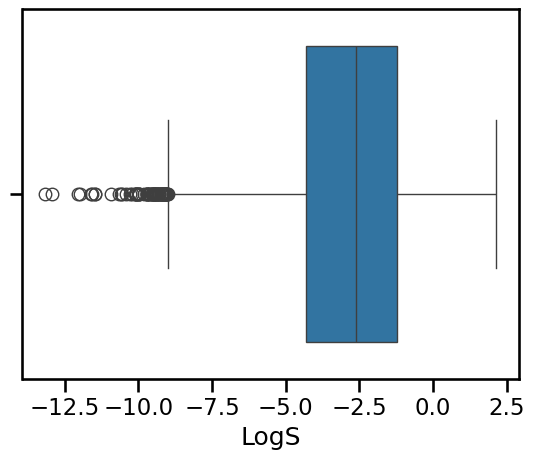

In [16]:
sns.boxplot(sol_df['LogS'], orient='h')

<Axes: >

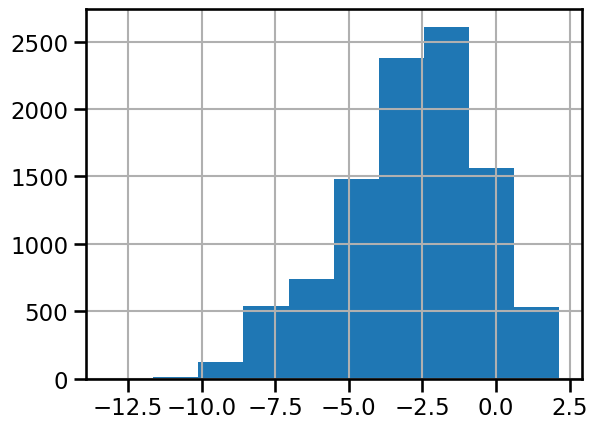

In [17]:
sol_df['LogS'].hist(bins=10)

Looks good! Now lets check for duplicates.

In [18]:
sol_df[sol_df['Name'].duplicated()]


,Name,SMILES,LogS
266,"(2E)-3,7-dimethylocta-2,6-dien-1-ol",CC(C)=CCC/C(C)=C/CO,-2.351910
460,5-methyl-2-(propan-2-yl)cyclohexan-1-ol,CC(C)[C@@H]1CC[C@@H](C)C[C@H]1O,-2.570624
660,"4-allyl-1,2-dimethoxybenzene",C/C=C/c1ccc(OC)c(OC)c1,-2.778227
672,"(2E)-3,7-dimethylocta-2,6-dien-1-yl acetate",CC(=O)OC/C=C(\C)CCC=C(C)C,-3.830500
1452,2-methylpropane,C[C](C)C,-4.376547
...,...,...,...
9970,quinine,C=CC1CN2CCC1C[C@H]2[C@H](O)c1ccnc2ccc(OC)cc12,-2.790000
9971,ranitidine,CN/C(=C\[N+](=O)[O-])NCCSCc1ccc(CN(C)C)o1,-2.500000
9973,sparfloxacin,C[C@H]1CN(c2c(F)c(N)c3c(=O)c(C(=O)O)cn(C4CC4)c...,-3.370000
9975,sulfasalazine,O=C(O)c1cc(/N=N/c2ccc(S(=O)(=O)Nc3ccccn3)cc2)c...,-6.140000


Shows that 89 rows have duplicate names. If we now use 'value_counts()', we will know how many of each type exist. 

In [19]:
sol_df['Name'].value_counts()

Name
tetracycline                                                                                                                                                                3
3,6-dimethylpiperazine-2,5-dione                                                                                                                                            2
propoxyphene                                                                                                                                                                2
nifuroxime                                                                                                                                                                  2
benzoximate                                                                                                                                                                 2
                                                                                                                             

E.g., 2-methylpropane exists twice and tetracycline exists 3 times. 

In [20]:
sol_df[sol_df['Name'] == '2-methylpropane']

,Name,SMILES,LogS
309,2-methylpropane,CC(C)C,-2.977604
1452,2-methylpropane,C[C](C)C,-4.376547


In [21]:
sol_df[sol_df['Name'] == 'tetracycline']

,Name,SMILES,LogS
3719,tetracycline,CN(C)[C@@H]1C(=O)/C(=C(\N)O)C(=O)[C@@]2(O)C(=O...,-3.284
8793,tetracycline,CN(C)C1C(O)=C(C(N)=O)C(=O)C2(O)C(O)=C3C(=O)c4c...,-3.120
9978,tetracycline,CN(C)[C@@H]1C(O)=C(C(N)=O)C(=O)[C@@]2(O)C(O)=C...,-2.930


In [22]:
sol_df[sol_df['Name'] == 'quinine']

,Name,SMILES,LogS
7461,quinine,C=CC1CN2CCC1CC2C(O)c1ccnc2ccc(OC)cc12,-2.79
9970,quinine,C=CC1CN2CCC1C[C@H]2[C@H](O)c1ccnc2ccc(OC)cc12,-2.79


Now if you observe, in most of these cases the Name is the same but the SMILES are different. Also the LogS value may or may not be the same. This shows that either there are some isomers, or different conformers, or different experimental conditions at which the LogS value was noted. There are multiple ways to approach this, we could remove them, or find the source of the data, reach out to authors who published the paper for clarification, etc. I'm just going to remove them here. 

In [23]:
new_df = sol_df.drop_duplicates(subset=['Name'])

In [24]:
new_df.shape

(9892, 3)

In [25]:
sol_df.shape

(9981, 3)

In [26]:
new_df.to_csv('./data/noduplicates.csv',index=False)